In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout, Input
from keras.optimizers import Adam
import matplotlib.pyplot as plt

In [ ]:
# Load and preprocess data
def load_and_preprocess_data(filepath):
    headers = ["datetime", "open", "high", "low", "close", "volume"]
    data = pd.read_csv(filepath, names=headers, header=0, parse_dates=['datetime'], index_col='datetime')
    # Feature Engineering
    data['price_change'] = data['close'].pct_change()
    data['volume_change'] = data['volume'].pct_change()
    data.dropna(inplace=True)
    # Check and handle NaN or infinite values
    data = data.replace([np.inf, -np.inf], np.nan).dropna()
    return data

In [ ]:
# Prepare features and labels
def prepare_features_labels(data):
    features = data[['open', 'high', 'low', 'close', 'volume', 'price_change', 'volume_change']].values
    labels = data['price_change'].values
    # Split into train and test sets
    train_size = int(len(features) * 0.8)
    train_features, test_features = features[:train_size], features[train_size:]
    train_labels, test_labels = labels[:train_size], labels[train_size:]
    return train_features, test_features, train_labels, test_labels, train_size

In [ ]:
# Normalize data
def normalize_data(train_features, test_features):
    scaler = MinMaxScaler(feature_range=(0, 1))
    train_features_scaled = scaler.fit_transform(train_features)
    test_features_scaled = scaler.transform(test_features)
    # Reshape for LSTM
    train_features_scaled = train_features_scaled.reshape((train_features_scaled.shape[0], 1, train_features_scaled.shape[1]))
    test_features_scaled = test_features_scaled.reshape((test_features_scaled.shape[0], 1, test_features_scaled.shape[1]))
    return train_features_scaled, test_features_scaled, scaler

In [ ]:
# Build LSTM model
def build_lstm_model(input_shape):
    model = Sequential()
    # First LSTM layer
    model.add(Input(shape=input_shape))
    model.add(LSTM(units=50, return_sequences=True))
    model.add(Dropout(0.2))
    # Second LSTM layer
    model.add(LSTM(units=50, return_sequences=True))
    model.add(Dropout(0.2))
    # Third LSTM layer
    model.add(LSTM(units=50, return_sequences=True))
    model.add(Dropout(0.2))
    # Fourth LSTM layer
    model.add(LSTM(units=50))
    model.add(Dropout(0.2))
    # Output layer
    model.add(Dense(units=1))
    # Compile the model
    model.compile(optimizer=Adam(learning_rate=0.001), loss='mean_squared_error', metrics=['accuracy'])
    return model


In [ ]:
# Train LSTM model
def train_lstm_model(model, train_features, train_labels, test_features, test_labels):
    history = model.fit(train_features, train_labels, epochs=50, batch_size=64, validation_data=(test_features, test_labels), verbose=2)
    return history


In [ ]:

# Evaluate LSTM model
def evaluate_lstm_model(model, test_features, test_labels):
    test_loss, test_accuracy = model.evaluate(test_features, test_labels, verbose=2)
    print(f"Test Loss: {test_loss}, Test Accuracy: {test_accuracy}")


In [ ]:
# Plot model accuracy and loss
def plot_training_history(history):
    plt.figure(figsize=(12, 4))

    # Plot accuracy
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('Model accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Test'], loc='upper left')

    # Plot loss
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Test'], loc='upper left')
    plt.show()

In [ ]:

# Backtest strategy with signal generation and plotting
def backtest_strategy(data, model, scaler, initial_capital, trade_percentage, train_size):
    capital = initial_capital
    trade_amount = trade_percentage * capital
    evolution = []
    signals = []

    # Prepare data for prediction
    data_model = data[['open', 'high', 'low', 'close', 'volume', 'price_change', 'volume_change']]
    data_model_scaled = scaler.transform(data_model)
    data_model_scaled = data_model_scaled.reshape((data_model_scaled.shape[0], 1, data_model_scaled.shape[1]))

    for i in range(len(data)):
        if i == 0:
            signals.append(0)  # No signal for the first data point
            continue

        entry_price = data['close'].iloc[i-1]
        order_size_btc = trade_amount / entry_price
        prediction = model.predict(data_model_scaled[i-1:i])
        predicted_change = prediction[0][0]

        if predicted_change > 0:
            signals.append(1)  # Buy signal
        elif predicted_change < 0:
            signals.append(-1)  # Sell signal
        else:
            signals.append(0)  # No trade

        # Backtesting logic for updating capital
        exit_price = data['close'].iloc[i]
        profit = 0
        if signals[-1] == 1:  # Buy
            capital -= trade_amount
            if exit_price >= entry_price * (1 + predicted_change):
                profit = (entry_price * (1 + predicted_change) - entry_price) * order_size_btc
            elif exit_price <= entry_price * (1 - abs(predicted_change)):
                profit = (entry_price * (1 - abs(predicted_change)) - entry_price) * order_size_btc
            else:
                profit = (exit_price - entry_price) * order_size_btc

        elif signals[-1] == -1:  # Sell
            capital -= trade_amount
            if exit_price <= entry_price * (1 + predicted_change):
                profit = (entry_price - entry_price * (1 + predicted_change)) * order_size_btc
            elif exit_price >= entry_price * (1 - abs(predicted_change)):
                profit = (entry_price - entry_price * (1 - abs(predicted_change))) * order_size_btc
            else:
                profit = (entry_price - exit_price) * order_size_btc

        capital += trade_amount + profit
        evolution.append(capital)
        trade_amount = trade_percentage * capital

    print(f'Final capital: {capital}')
    signal_df = pd.DataFrame(index=data.index, data=signals, columns=['Signal'])
    signal_df.to_excel('trading_signals.xlsx')

    # Plot evolution of profits
    plt.figure(figsize=(15, 8))
    plt.plot(evolution, label='Capital Evolution')
    plt.xlabel('Trades')
    plt.ylabel('Capital')
    plt.title('Evolution of Capital')
    plt.legend()
    plt.show()

    # Plot buy/sell signals
    plot_signals(data, signal_df)


In [ ]:
# Plot signals on price data
def plot_signals(data, signal_df):
    plt.figure(figsize=(15, 8))
    plt.plot(data.index, data['close'], label='Close Price', color='blue')
    buy_signals = signal_df[signal_df['Signal'] == 1]
    sell_signals = signal_df[signal_df['Signal'] == -1]
    plt.plot(buy_signals.index, data.loc[buy_signals.index, 'close'], '^', markersize=10, color='green', label='Buy Signal')
    plt.plot(sell_signals.index, data.loc[sell_signals.index, 'close'], 'v', markersize=10, color='red', label='Sell Signal')
    plt.title('Trading Signals')
    plt.xlabel('Date')
    plt.ylabel('Price')
    plt.legend()
    plt.show()


Epoch 1/50
446/446 - 12s - 27ms/step - accuracy: 3.8559e-04 - loss: 7.8267e-05 - val_accuracy: 1.4021e-04 - val_loss: 6.6690e-05
Epoch 2/50
446/446 - 6s - 13ms/step - accuracy: 3.8559e-04 - loss: 2.7786e-05 - val_accuracy: 1.4021e-04 - val_loss: 3.5355e-06
Epoch 3/50
446/446 - 5s - 11ms/step - accuracy: 3.8559e-04 - loss: 4.2232e-06 - val_accuracy: 1.4021e-04 - val_loss: 4.7048e-08
Epoch 4/50
446/446 - 4s - 8ms/step - accuracy: 3.8559e-04 - loss: 3.4234e-06 - val_accuracy: 1.4021e-04 - val_loss: 1.4968e-06
Epoch 5/50
446/446 - 3s - 8ms/step - accuracy: 3.8559e-04 - loss: 3.3825e-06 - val_accuracy: 1.4021e-04 - val_loss: 3.0419e-06
Epoch 6/50
446/446 - 4s - 10ms/step - accuracy: 3.8559e-04 - loss: 2.7725e-06 - val_accuracy: 1.4021e-04 - val_loss: 1.7189e-06
Epoch 7/50
446/446 - 4s - 10ms/step - accuracy: 3.8559e-04 - loss: 2.6728e-06 - val_accuracy: 1.4021e-04 - val_loss: 9.7556e-07
Epoch 8/50
446/446 - 5s - 11ms/step - accuracy: 3.8559e-04 - loss: 3.0305e-06 - val_accuracy: 1.4021e-04 

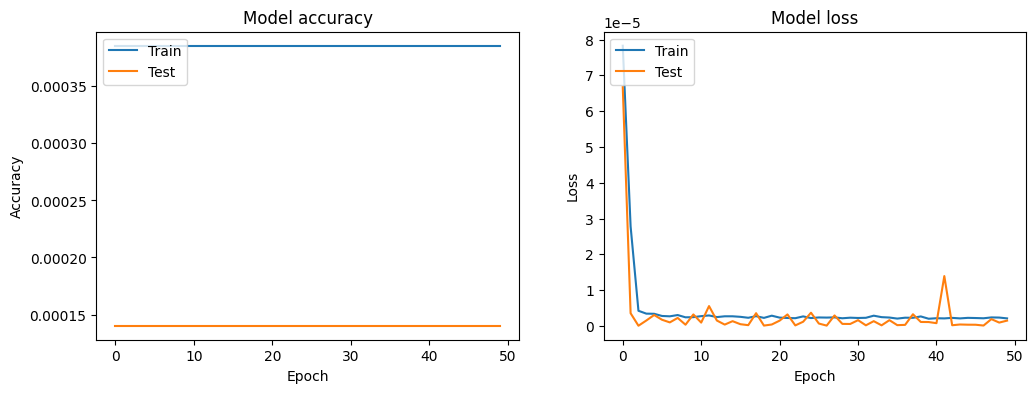

In [ ]:
# Main execution
filepath = "/content/drive/MyDrive/Colab Notebooks/research/btc_1h.csv"
data = load_and_preprocess_data(filepath)
train_features, test_features, train_labels, test_labels, train_size = prepare_features_labels(data)
train_features_scaled, test_features_scaled, scaler = normalize_data(train_features, test_features)
input_shape = (train_features_scaled.shape[1], train_features_scaled.shape[2])  # Correct input shape
model = build_lstm_model(input_shape)
history = train_lstm_model(model, train_features_scaled, train_labels, test_features_scaled, test_labels)
evaluate_lstm_model(model, test_features_scaled, test_labels)
plot_training_history(history)


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:458: UserWarning: X has feature names, but MinMaxScaler was fitted without feature names
  warnings.warn(


Streaming output truncated to the last 5000 lines.
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step

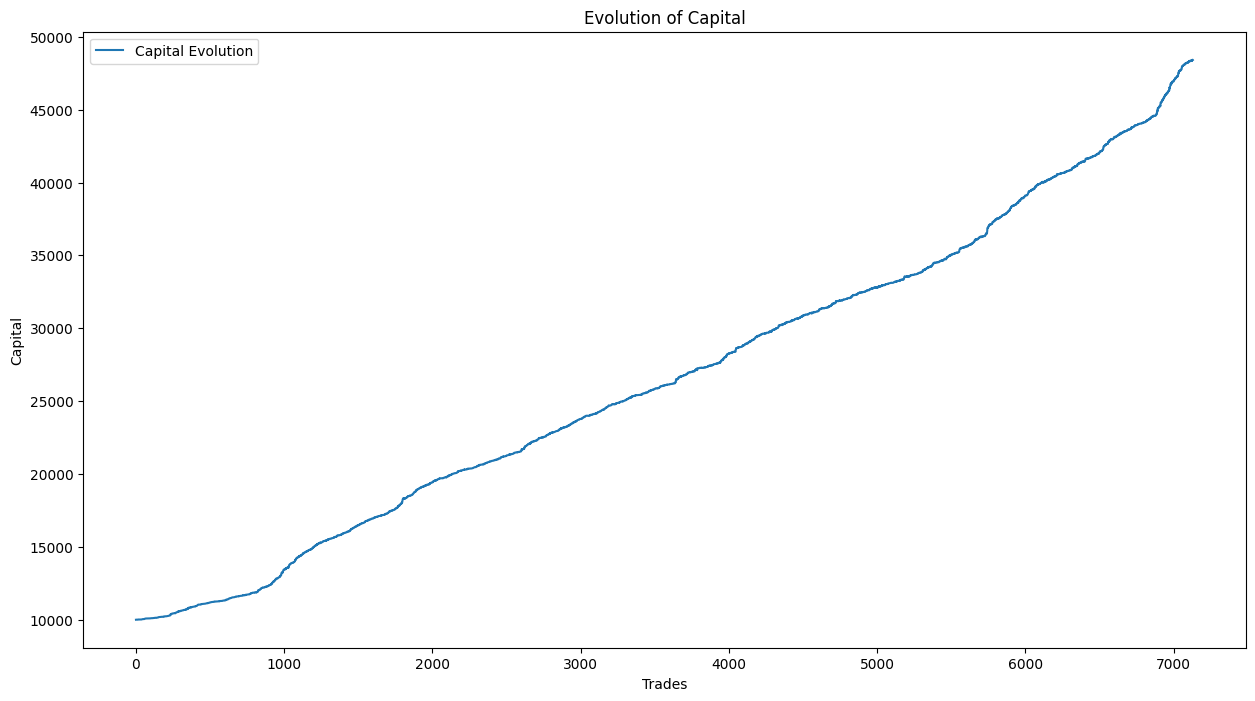

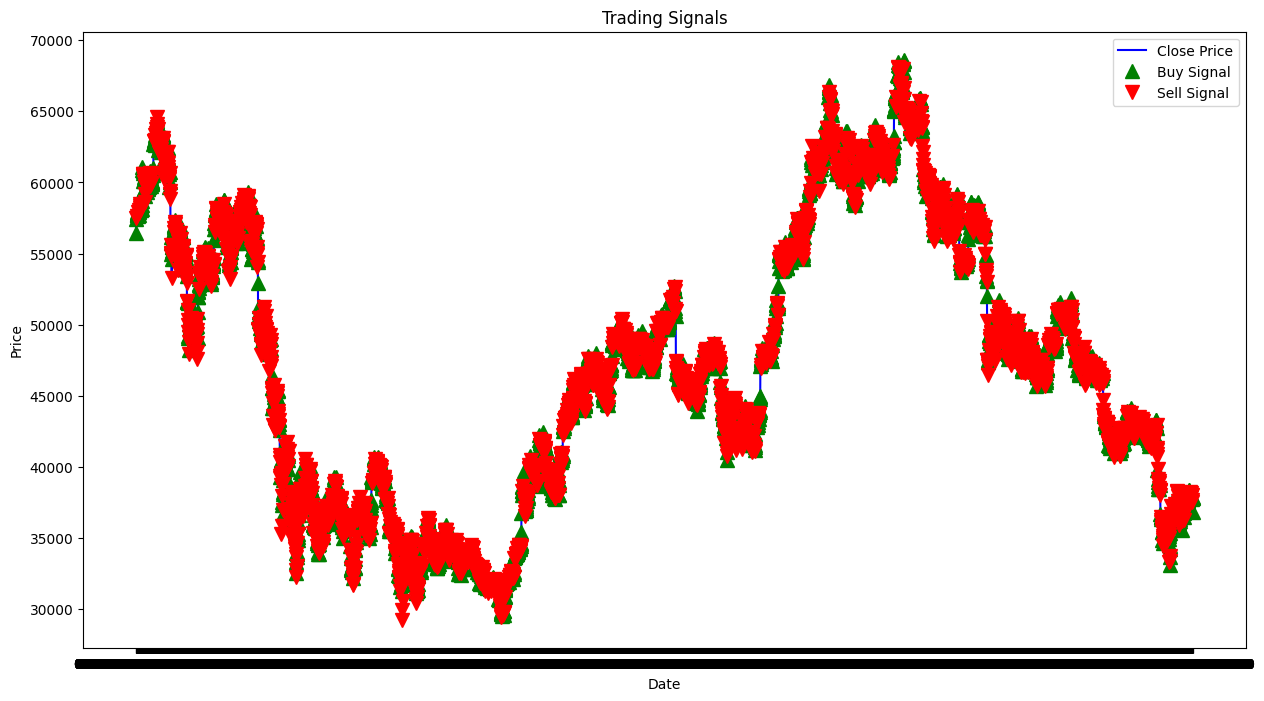

In [ ]:
# Backtesting and plotting
backtest_strategy(data.iloc[train_size:], model, scaler, initial_capital=10000, trade_percentage=0.1, train_size=train_size)


In [ ]:
# Load and preprocess new data
def load_and_preprocess_new_data(filepath):
    headers = ["datetime", "open", "high", "low", "close", "volume"]
    data = pd.read_csv(filepath, names=headers, header=0, parse_dates=['datetime'], index_col='datetime')
    # Feature Engineering
    data['price_change'] = data['close'].pct_change()
    data['volume_change'] = data['volume'].pct_change()
    data.dropna(inplace=True)
    # Check and handle NaN or infinite values
    data = data.replace([np.inf, -np.inf], np.nan).dropna()
    return data


In [ ]:
# Prepare features and labels
def prepare_new_features_labels(data):
    features = data[['open', 'high', 'low', 'close', 'volume', 'price_change', 'volume_change']].values
    labels = data['price_change'].values
    return features, labels


In [ ]:
# Normalize new data
def normalize_new_data(features, scaler):
    features_scaled = scaler.transform(features)
    # Reshape for LSTM
    features_scaled = features_scaled.reshape((features_scaled.shape[0], 1, features_scaled.shape[1]))
    return features_scaled


In [ ]:
# Evaluate model on new data
def evaluate_model_on_new_data(model, new_features, new_labels):
    loss, accuracy = model.evaluate(new_features, new_labels, verbose=2)
    print(f"Out-of-sample Test Loss: {loss}, Out-of-sample Test Accuracy: {accuracy}")

In [ ]:
# Backtest strategy with signal generation and plotting
def backtest_strategy(data, model, scaler, initial_capital, trade_percentage):
    capital = initial_capital
    trade_amount = trade_percentage * capital
    evolution = []
    signals = []
    predictions = []

    # Prepare data for prediction
    data_model = data[['open', 'high', 'low', 'close', 'volume', 'price_change', 'volume_change']]
    data_model_scaled = scaler.transform(data_model)
    data_model_scaled = data_model_scaled.reshape((data_model_scaled.shape[0], 1, data_model_scaled.shape[1]))

    for i in range(len(data)):
        if i == 0:
            signals.append(0)  # No signal for the first data point
            continue

        entry_price = data['close'].iloc[i-1]
        order_size_btc = trade_amount / entry_price
        prediction = model.predict(data_model_scaled[i-1:i])
        predicted_change = prediction[0][0]
        predictions.append(predicted_change)

        if predicted_change > 0:
            signals.append(1)  # Buy signal
        elif predicted_change < 0:
            signals.append(-1)  # Sell signal
        else:
            signals.append(0)  # No trade

        # Backtesting logic for updating capital
        exit_price = data['close'].iloc[i]
        profit = 0
        if signals[-1] == 1:  # Buy
            capital -= trade_amount
            if exit_price >= entry_price * (1 + predicted_change):
                profit = (entry_price * (1 + predicted_change) - entry_price) * order_size_btc
            elif exit_price <= entry_price * (1 - abs(predicted_change)):
                profit = (entry_price * (1 - abs(predicted_change)) - entry_price) * order_size_btc
            else:
                profit = (exit_price - entry_price) * order_size_btc

        elif signals[-1] == -1:  # Sell
            capital -= trade_amount
            if exit_price <= entry_price * (1 + predicted_change):
                profit = (entry_price - entry_price * (1 + predicted_change)) * order_size_btc
            elif exit_price >= entry_price * (1 - abs(predicted_change)):
                profit = (entry_price - entry_price * (1 - abs(predicted_change))) * order_size_btc
            else:
                profit = (entry_price - exit_price) * order_size_btc

        capital += trade_amount + profit
        evolution.append(capital)
        trade_amount = trade_percentage * capital

    print(f'Final capital: {capital}')
    signal_df = pd.DataFrame(index=data.index, data=signals, columns=['Signal'])
    signal_df.to_excel('trading_signals.xlsx')

    # Plot evolution of profits
    plt.figure(figsize=(15, 8))
    plt.plot(evolution, label='Capital Evolution')
    plt.xlabel('Trades')
    plt.ylabel('Capital')
    plt.title('Evolution of Capital')
    plt.legend()
    plt.show()

    # Plot buy/sell signals
    plot_signals(data, signal_df)

    # Plot predicted vs actual price change
    plot_predicted_vs_actual(data, predictions)


In [ ]:
# Plot signals on price data
def plot_signals(data, signal_df):
    plt.figure(figsize=(15, 8))
    plt.plot(data.index, data['close'], label='Close Price', color='blue')

    buy_signals = signal_df[signal_df['Signal'] == 1]
    sell_signals = signal_df[signal_df['Signal'] == -1]

    plt.plot(buy_signals.index, data.loc[buy_signals.index, 'close'], '^', markersize=10, color='green', label='Buy Signal')
    plt.plot(sell_signals.index, data.loc[sell_signals.index, 'close'], 'v', markersize=10, color='red', label='Sell Signal')

    plt.title('Trading Signals')
    plt.xlabel('Date')
    plt.ylabel('Price')
    plt.legend()
    plt.show()

In [ ]:
# Plot predicted vs actual price changes
def plot_predicted_vs_actual(data, predictions):
    plt.figure(figsize=(15, 8))
    plt.plot(data.index[1:], data['price_change'][1:], label='Actual Price Change', color='blue')
    plt.plot(data.index[1:], predictions, label='Predicted Price Change', color='red')
    plt.title('Predicted vs Actual Price Change')
    plt.xlabel('Date')
    plt.ylabel('Price Change')
    plt.legend()
    plt.show()

<ipython-input-33-428d03d2be3f>:4: UserWarning: Parsing dates in %d-%m-%Y %H:%M format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  data = pd.read_csv(filepath, names=headers, header=0, parse_dates=['datetime'], index_col='datetime')


21/21 - 0s - 15ms/step - accuracy: 0.0000e+00 - loss: 1.2232e-06
Out-of-sample Test Loss: 1.2232140988999163e-06, Out-of-sample Test Accuracy: 0.0


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:458: UserWarning: X has feature names, but MinMaxScaler was fitted without feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━

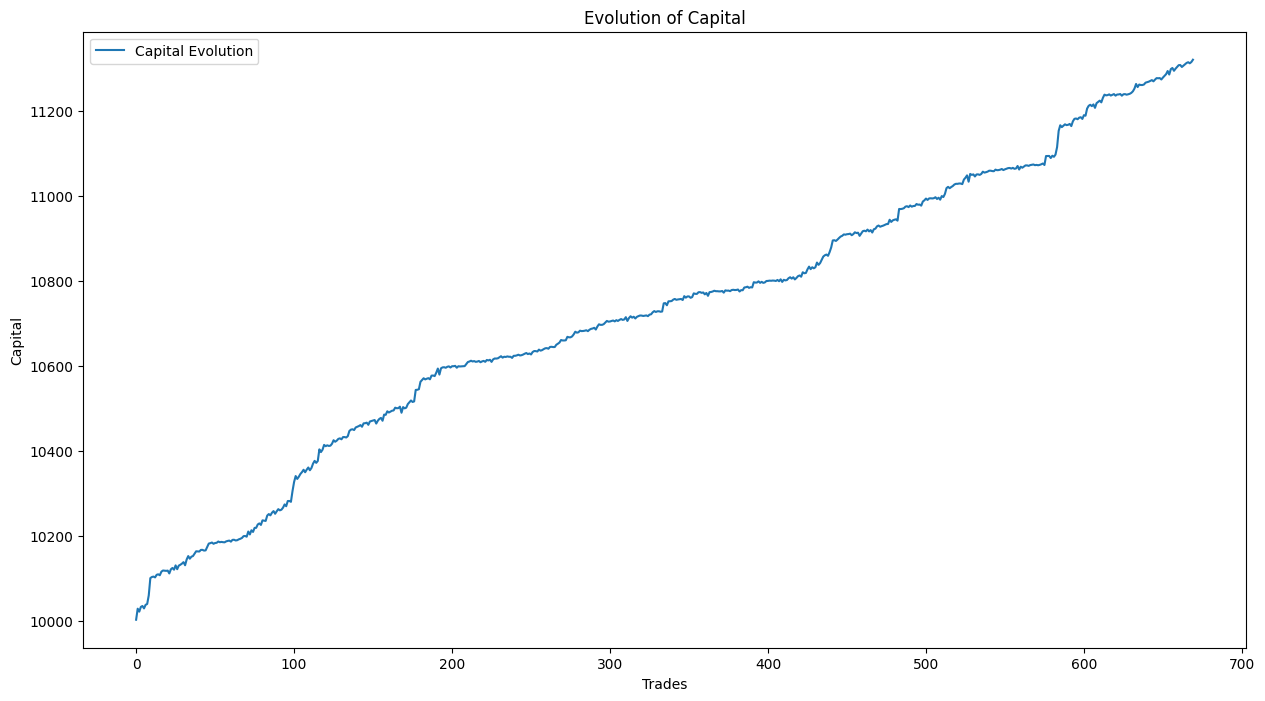

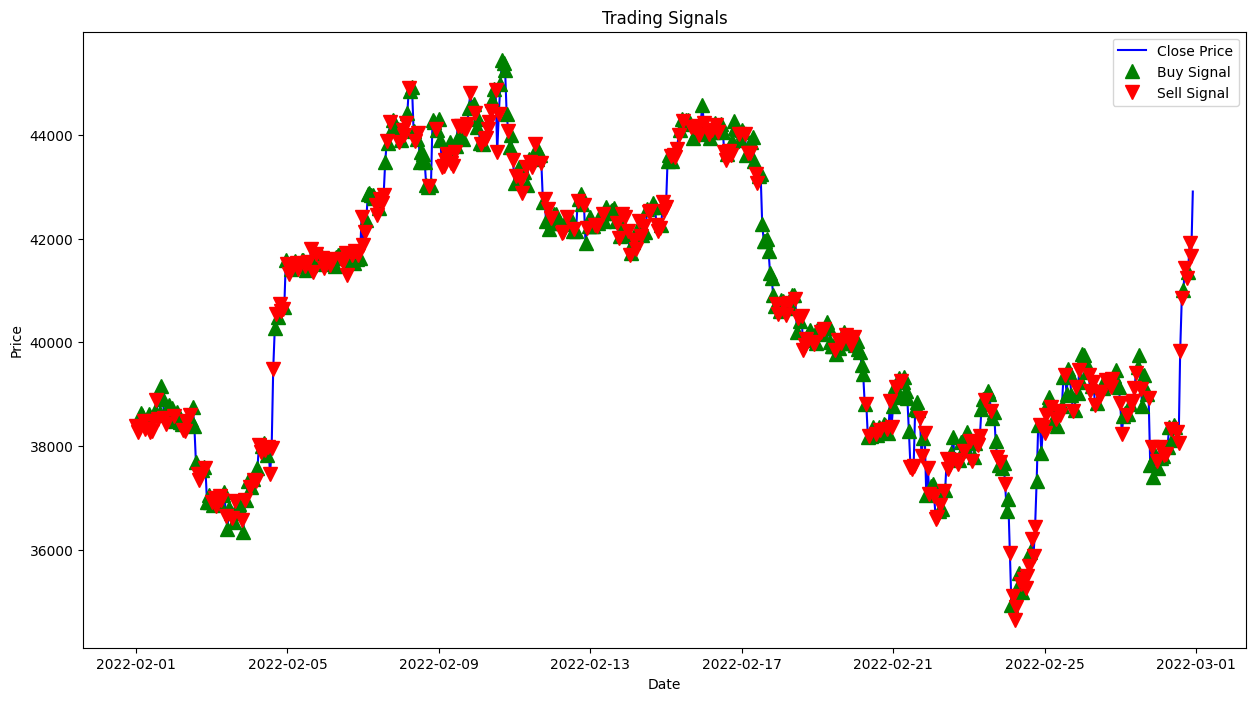

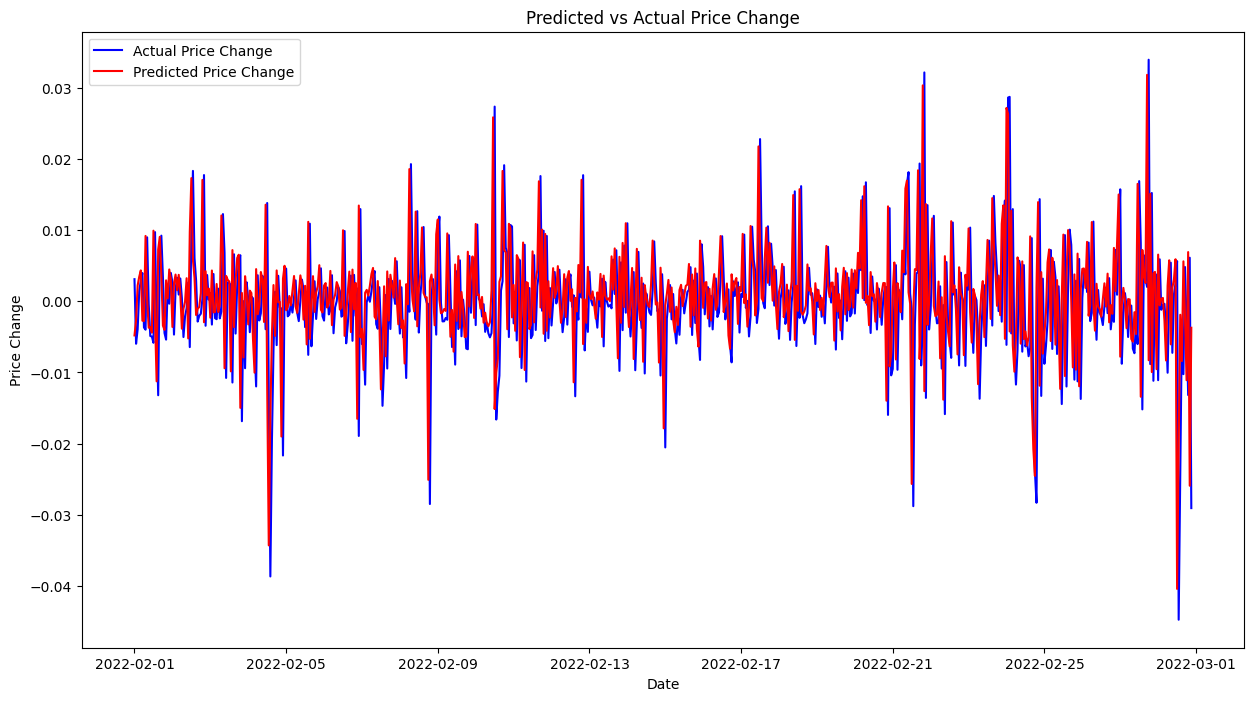

In [ ]:
# Main execution for out-of-sample testing and trading
new_filepath = "/content/drive/MyDrive/Colab Notebooks/research/Copy of outos.csv"  # Replace with the path to your new dataset
new_data = load_and_preprocess_new_data(new_filepath)
new_features, new_labels = prepare_new_features_labels(new_data)
new_features_scaled = normalize_new_data(new_features, scaler)
evaluate_model_on_new_data(model, new_features_scaled, new_labels)

# Perform trading and plot signals
backtest_strategy(new_data, model, scaler, initial_capital=10000, trade_percentage=0.1)
